<a href="https://colab.research.google.com/github/Vrushali-M/Fall_2019_ML_project/blob/master/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#root_path = r'/gdrive/My Drive/ML_project/'  #change dir to project folder
#drive.mount(root_path)
#ValueError: Mountpoint must not contain a space.

Mounted at /content/gdrive


In [0]:
# Run Once only 
#!mkdir 'gdrive/My Drive/ML_project/data'

#!unzip 'gdrive/My Drive/ML_project/ieee-fraud-detection.zip'  -d 'gdrive/My Drive/ML_project/data'

In [0]:
!ls 'gdrive/My Drive/ML_project/data'

sample_submission.csv  test_transaction.csv  train_identity.html
test_identity.csv      train_identity.csv    train_transaction.csv


In [0]:
data_path = r'gdrive/My Drive/ML_project/data'

PreProcessing


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import pandas_profiling
import os

%matplotlib inline
%tensorflow_version 1.x

Load Data


In [0]:
path1 = os.path.join(data_path, 'test_transaction.csv')
path2 = os.path.join(data_path, 'test_identity.csv')

In [0]:

#!chmod 777 -R 'gdrive/My Drive/ML_project/data'

In [0]:
train_transactions = pd.read_csv(path1, engine='python')
train_identity = pd.read_csv(path2, engine='python')
print('Train data set is loaded')

Train data set is loaded


Data Insights


In [0]:
train_transactions.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train_transactions.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,36436.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,501943.000000,506688.000000,500660.000000,271922.000000,303549.000000,429840.000000,282316.000000,124783.000000,60133.000000,74338.000000,74338.000000,494146.000000,330173.000000,69254.000000,123384.000000,115194.000000,494622.000000,...,500660.000000,500660.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,500660.000000,500660.000000,500660.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,7.643100e+04,7.643100e+04,7.643100e+04,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412,87.065270,237.175047,10.093211,10.714635,0.027403,2.385875,4.962701,6.854992,1.678173,1.893994,4.611943,1.810149,7.484594,2.649486,27.816035,6.083890,108.207504,188.666621,33.394727,175.060799,50.977752,82.443145,61.815642,160.834483,0.553981,159.810552,218.414895,77.404179,18.225961,58.163186,206.854137,...,0.056685,0.065931,0.286762,0.321849,0.301547,1.000002,83.783107,259.371829,136.949416,12.838856,127.198552,5.153783,42.733066,21.238136,43.269524,26.730428,42.077887,83.808337,56.090776,27.620156,46.835629,36.772511,0.436681,1.216182,0.693514,0.047926,0.482658,0.163271,0.220486,0.460572,0.309900,3.151286e+02,4.404643e+02,3.811021e+02,24.708030,58.339468,35.485643,99.058760,155.578153,139.814706
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328,314.131694,556.450834,79.334782,88.896921,0.227753,41.942977,25.462195,46.783565,37.874827,26.766115,21.282640,23.692393,61.322505,53.973060,101.114033,28.315616,176.964526,197.099611,82.558210,250.417470,116.829786,192.867671,150.299612,257.003738,0.317327,240.566557,253.091693,176.218548,78.079890,164.015525,269.419196,...,0.336923,0.370363,0.502396,0.639583,0.555264,0.001405,2706.035763,3643.584651,2976.740478,337.427648,606.911563,278.305451,467.654628,94.662615,195.591901,115.676311,2249.338097,2919.418027,2263.811948,999.900445,1514.927745,1486.814768,2.129226,5.925144,3.343788,0.282497,2.555532,0.850853,1.789616,4.228813,2.632181,9.494045e+03,1.064843e+04,1.039556e+04,842.913287,990.361078,904.093921,2436.074522,4544.303974,4493.728267
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.000000,150.0

In [0]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [0]:
train_identity.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.419070e+05,141907.000000,136976.000000,66481.000000,66481.000000,134750.000000,134750.000000,5059.000000,5059.000000,74338.000000,74338.000000,136778.000000,130286.000000,71357.000000,135966.000000,50875.000000,135906.000000,135633.000000,5059.000000,5062.000000,4740.000000,5039.000000,5047.000000,70671.000000
mean,3.972166e+06,-11.325734,192658.729909,0.053008,-0.087454,1.246033,-6.803829,12.493180,-36.577782,0.076219,-0.245877,99.750876,36.905715,-344.482672,191.070341,14.795735,350.122982,408.886230,507.727021,15.336823,13.166667,332.043064,152.752923,26.217939
std,1.469966e+05,14.508520,182613.277215,0.684551,0.840351,5.071394,15.921457,11.678206,25.544185,1.009687,2.120525,1.119819,13.206713,93.633156,30.749535,2.318496,139.140824,158.971756,227.371061,5.618032,3.222440,86.356683,31.916995,3.601046
min,3.663586e+06,-100.000000,2.000000,-12.000000,-19.000000,-81.000000,-100.000000,-41.000000,-100.000000,-32.000000,-100.000000,90.000000,11.000000,-720.000000,100.000000,11.000000,100.000000,100.000000,100.000000,11.000000,10.000000,100.000000,100.000000,8.000000
25%,3.859268e+06,-12.500000,63339.500000,0.000000,0.000000,0.000000,-6.000000,3.000000,-46.000000,0.000000,0.000000,100.000000,27.000000,-360.000000,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,137.000000,24.000000
50%,4.001774e+06,-5.000000,133189.500000,0.000000,0.000000,0.000000,0.000000,12.000000,-33.000000,0.000000,0.000000,100.000000,27.000000,-300.000000,166.000000,15.000000,321.000000,484.000000,576.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,4.105284e+06,-5.000000,265717.500000,0.000000,0.000000,1.000000,0.000000,21.000000,-23.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,15.000000,427.000000,549.000000,711.000000,14.000000,15.000000,355.000000,182.000000,32.000000
max,4.170239e+06,0.000000,999869.000000,11.000000,0.000000,52.000000,0.000000,59.000000,0.000000,16.000000,0.000000,100.000000,63.000000,720.000000,228.000000,29.000000,670.000000,660.000000,854.000000,44.000000,26.000000,549.000000,216.000000,48.000000


In [0]:
## Run only once

#from pandas_profiling import ProfileReport

#profile_train_identity = ProfileReport(train_identity)
#profile_train_identity.to_file(data_path+"/train_identity.html")

#profile_train_trans = ProfileReport(train_transactions)
#profile_train_trans.to_file(data_path+"/train_transactions.html")

In [0]:
### Imputation of missing values

In [0]:
def sizeDown(df,cols, type2):
    for l in cols:
        df[l] = np.round(pd.to_numeric(df[l], downcast= type2), 5)
    return df

In [0]:
def get_columns_by_group(df):
    """Returns the number of types and dictionary of with values dataframes and key as type"""
    column_types = df.columns.to_series().groupby(df.dtypes).groups
    k = list(column_types.keys())
    list_df = {}
    for i in k:
        list_df[i] = (df[column_types[i]])
    return list_df, k

In [0]:
def downsize_numericals(df):
    column_types = df.columns.to_series().groupby(df.dtypes).groups
    k = list(column_types.keys())
    for i in k:
        if str(i) == 'float64':
            df[column_types[i]] = sizeDown(df[column_types[i]], column_types[i], "float")
        elif str(i) == 'int64':
            df[column_types[i]] = sizeDown(df[column_types[i]], column_types[i], "integer")
        else:
            pass
    return df

In [0]:
train_transactions = downsize_numericals(train_transactions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_transactions_info = get_columns_by_group(train_transactions)

In [0]:
train_transactions_info[1]

[dtype('int16'), dtype('int32'), dtype('float32'), dtype('O')]

In [0]:
train_transactions_info[0][train_transactions_info[1][1]]

,TransactionID,TransactionDT
0,3663549,18403224
1,3663550,18403263
2,3663551,18403310
3,3663552,18403310
4,3663553,18403317
...,...,...
506686,4170235,34214279
506687,4170236,34214287
506688,4170237,34214326
506689,4170238,34214337


In [0]:
train_transactions_info[0][train_transactions_info[1][0]].isna().count()

## No missing

card1    506691
dtype: int64

In [0]:
train_transactions_info[0][train_transactions_info[1][1]].isna().count()


## no missing

TransactionID    506691
TransactionDT    506691
dtype: int64

In [0]:
train_transactions_info[0][train_transactions_info[1][3]]

## needs to be encoded first

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,visa,debit,gmail.com,NaN,T,T,F,NaN,NaN,F,T,T,T
1,W,visa,debit,aol.com,NaN,T,F,F,M0,NaN,F,NaN,NaN,NaN
2,W,visa,debit,hotmail.com,NaN,T,T,F,M0,F,F,F,F,F
3,W,visa,debit,gmail.com,NaN,T,T,T,NaN,NaN,T,NaN,NaN,NaN
4,W,mastercard,debit,gmail.com,NaN,T,T,T,NaN,NaN,F,F,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,C,mastercard,debit,gmail.com,gmail.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
506687,C,mastercard,debit,hotmail.com,hotmail.com,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
506688,W,visa,debit,hotmail.com,NaN,T,T,T,M0,F,F,F,T,T
506689,W,mastercard,debit,hotmail.com,NaN,T,T,T,M0,F,F,F,F,F


In [0]:
### Label Encoding

In [0]:
## preprocessing the numerical columns
temp = train_transactions_info[0][train_transactions_info[1][2]]
temp.head()


,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,31.950001,111.0,150.0,226.0,170.0,87.0,1.0,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.000000,111.0,150.0,226.0,299.0,87.0,4.0,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,171.000000,574.0,150.0,226.0,472.0,87.0,2635.0,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,NaN,NaN,NaN,97.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,284.950012,360.0,150.0,166.0,205.0,87.0,17.0,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,NaN,NaN,NaN,242.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67.949997,452.0,150.0,117.0,264.0,87.0,6.0,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=5, verbose=1, n_nearest_features=6)
temp_df = imp.fit_transform(temp)
temp_df = pd.DataFrame(temp_df, columns=temp.columns)

[IterativeImputer] Completing matrix with shape (506691, 376)


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [0]:
# from fancyimpute import KNN    
# # X is the complete data matrix
# # X_incomplete has the same values as X except a subset have been replace with NaN

# # Use 3 nearest rows which have a feature to fill in each row's missing features
# X_filled_knn = KNN(k=3).fit_transform(train_transactions)

In [0]:
temp_df.head()

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,31.950001,111.0,150.0,226.0,170.0,87.0,1.0,202.595375,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,326.173282,121.227608,218.517650,0.607718,418.0,203.0,370.684473,65.025073,115.162382,409.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.145608,-1.180917,-0.495422,0.035102,1.105479,0.050808,-0.002899,0.049509,-0.250488,-10.119368,35.774398,39.557377,2.137111,29.822622,8.843979,42.608744,7.108251,37.150506
1,49.000000,111.0,150.0,226.0,299.0,87.0,4.0,200.518677,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,199.543725,117.353910,207.132358,0.607793,231.0,634.0,588.724035,33.775700,76.053470,634.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.473929,1.900117,-0.476635,0.037715,4.252465,0.934966,-0.002808,-0.022899,-0.139568,-80.263878,221.598056,174.025079,9.977857,55.787058,34.783784,5.419889,-11.968583,25.931072
2,171.000000,574.0,150.0,226.0,472.0,87.0,2635.0,192.063417,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,147.311338,117.479331,210.494967,0.610895,136.0,136.0,92.366957,22.124696,59.867779,97.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,-0.358401,3.271943,-0.281827,0.055414,3.188819,0.013962,0.067895,0.214634,0.120235,-314.834198,874.231698,391.058831,32.981349,151.327504,119.982041,-69.033436,-180.343913,-90.308527
3,284.950012,360.0,150.0,166.0,205.0,87.0,17.0,201.684997,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,197.946115,117.440282,205.174625,0.607987,242.0,242.0,226.381641,21.318340,89.946344,242.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,0.054679,-0.712040,-0.496814,0.278448,0.215066,0.055343,-0.002602,-0.124235,-0.064943,-94.498892,31.077880,12.937712,-0.179073,24.320272,3.557611,57.459821,139.041333,136.393212
4,67.949997,452.0,150.0,117.0,264.0,87.0,6.0,199.483534,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,77.007632,119.156288,211.883865,0.608390,22.0,22.0,23.083599,20.418040,37.852613,22.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,0.043543,2.374174,-0.242031,0.267210,3.346537,0.958294,0.931602,0.042430,-0.034007,-9.170953,139.990145,111.608574,68.310108,104.410888,81.221075,92.850462,-12.612875,25.461871


In [0]:
temp_df.describe()

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,...,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,5.066910e+05,5.066910e+05,5.066910e+05,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000
mean,134.725568,363.745181,153.551197,200.157266,294.172879,85.478089,94.598051,210.931126,10.092669,10.714253,0.027403,2.385794,4.962497,6.854951,1.678559,1.894300,4.611749,1.811105,7.484229,2.649365,27.731240,6.083314,107.556548,222.102913,34.669627,176.367239,39.047226,154.418567,104.757674,190.514025,0.592192,159.745754,174.609218,170.631170,30.247755,80.034825,206.064220,0.999793,1.073242,1.093246,...,0.056562,0.065971,0.286765,0.321852,0.301549,1.000002,83.782001,259.370724,136.948013,12.838699,127.197332,5.153687,42.732857,21.158464,43.020550,26.656048,42.077562,83.807598,56.089935,27.620065,46.835555,36.772368,0.202752,0.907751,-0.047053,0.084751,1.069309,0.288816,0.169883,0.215503,0.140614,7.834999e+01,2.165519e+02,2.385815e+02,13.789722,51.775893,29.763375,43.315972,11.227939,39.508481
std,245.779823,157.340020,12.417648,40.387304,95.429978,4.400609,206.119076,150.582937,79.334860,88.896797,0.227752,41.942867,25.462258,46.783429,37.875048,26.766331,21.282726,23.695576,61.322508,53.972924,100.672420,28.316523,176.225173,150.221458,64.359848,232.856099,92.226196,161.062473,56.884136,104.623449,0.125377,237.678140,231.741888,226.265685,44.829668,91.970544,266.601346,0.014190,0.317811,0.303040,...,0.334949,0.369109,0.502397,0.639584,0.555265,0.001405,2706.027776,3643.573879,2976.731710,337.426656,606.909978,278.304631,467.653251,94.161132,194.456092,114.998842,2249.331420,2919.409355,2263.805254,999.897488,1514.923265,1486.810370,1.141751,3.972447,1.539348,0.168130,2.583552,0.786685,0.842154,1.858540,1.220130,3.712869e+03,4.181549e+03,4.090728e+03,331.566327,392.636682,359.172458,947.870906,1772.666804,1753.147169
min,0.018000,100.000000,100.000000,100.000000,100.000000,10.000000,-46.672196,-266.543260,-85.045769,-57.404529,0.000000,-13.196388,-29.938204,-0.935674,0.000000,0.000000,-28.476759,0.000000,-56.364718,-20.066898,-177.582564,-92.633379,-94.416800,-230.012015,-297.793628,-860.930411,-1992.755136,-214.693356,-248.439940,-747.514838,-0.737921,-266.562955,-263.297695,-182.010774,-615.571137,-689.930611,-2565.464538,-0.002452,-10.001209,-0.453968,...,-0.086459,-0.288857,0.000000,-0.005544,-0.004895,1.000000,-168.809780,0.000000,-172.719361,-22.128599,-111.368858,-19.796791,0.000000,-9.779029,-177.774402,-40.533553,-15.940272,-69.523757,-122.035186,-8.714083,0.000000,-18.527596,-4.228501,-5.702086,-1.224535,-1.429600,-0.191915,-0.414420,-1.339385,-6.155330,-10.449724,-5.705554e+03,-3.447365e+03,-1.379389e+03,-16.075063,-110.736090,-23.148383,-735.742

## PCA


In [0]:
from sklearn.decomposition import PCA

#data_v = {'C1', 'C2', 'C3', 'C4',	'C5',	'C6',	'C7',	'C8', C9	C10	C11	C12	C13	C14}


# PCA C1 to C14
temp_df.iloc[:, 8:22]
pca_C = PCA(n_components=1)
pComp_C = pca_C.fit_transform(temp_df.iloc[:, 8:22])




In [0]:
# PCA D1 to D15
temp_df.iloc[:, 22:37]
pca_D = PCA(n_components=1)
pComp_D = pca_D.fit_transform(temp_df.iloc[:, 23:])



In [0]:
# PCA V1 to V339
temp_df.iloc[:, 37:]
pca_V = PCA(n_components=1)
pComp_V = pca_V.fit_transform(temp_df.iloc[:, 37:])



In [0]:
pca_out_C = pd.DataFrame(data = pComp_C, columns = ['C'])

pca_out_D = pd.DataFrame(data = pComp_D, columns = ['D'])

pca_out_V = pd.DataFrame(data = pComp_V, columns = ['V'])

print(pca_out_C.head(), pca_out_D.head(), pca_out_V.head())


           C
0  24.599117
1 -20.021078
2 -15.521164
3 -20.523461
4 -12.489151                D
0 -190344.674018
1 -186162.935394
2 -199992.292025
3 -190595.537641
4 -189599.253299                V
0 -190344.523866
1 -186162.663187
2 -199992.357273
3 -190595.496544
4 -189599.395695


In [0]:
# a=pd.DataFrame(data = temp_df[:, 0:8])
# a
# pca_out_C.reset_index(drop=True, inplace=True)
# #pca_out_D.reset_index(drop=True, inplace=True)
# #pca_out_V.reset_index(drop=True, inplace=True)

pca_df = pd.concat([temp_df.iloc[:, 0:8], pca_out_C, pca_out_D, pca_out_V], axis=1)
pca_df

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C,D,V
0,31.950001,111.0,150.0,226.0,170.000000,87.000000,1.000000,202.595375,24.599117,-190344.674018,-190344.523866
1,49.000000,111.0,150.0,226.0,299.000000,87.000000,4.000000,200.518677,-20.021078,-186162.935394,-186162.663187
2,171.000000,574.0,150.0,226.0,472.000000,87.000000,2635.000000,192.063417,-15.521164,-199992.292025,-199992.357273
3,284.950012,360.0,150.0,166.0,205.000000,87.000000,17.000000,201.684997,-20.523461,-190595.537641,-190595.496544
4,67.949997,452.0,150.0,117.0,264.000000,87.000000,6.000000,199.483534,-12.489151,-189599.253299,-189599.395695
...,...,...,...,...,...,...,...,...,...,...,...
506686,94.679001,375.0,185.0,224.0,284.000000,60.000000,114.032727,201.812052,-25.351811,698420.468047,698420.355432
506687,12.173000,408.0,185.0,224.0,309.031190,77.633594,113.997663,157.000000,-23.090653,693996.629795,693996.525392
506688,49.000000,490.0,150.0,226.0,327.000000,87.000000,110.022086,201.770724,-25.959728,-188744.258336,-188744.419573
506689,202.000000,516.0,150.0,224.0,177.000000,87.000000,110.022086,201.762586,-25.959728,-188984.720714,-188984.881964


In [0]:
pca_df_reduced = pd.concat([temp_df.iloc[:, 0:8], pca_out_C/pca_out_C.max(), pca_out_D/pca_out_D.max(), pca_out_V/pca_out_V.max()], axis=1)
pca_df_reduced

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C,D,V
0,31.950001,111.0,150.0,226.0,170.000000,87.000000,1.000000,202.595375,0.004051,-0.042263,-0.042263
1,49.000000,111.0,150.0,226.0,299.000000,87.000000,4.000000,200.518677,-0.003297,-0.041335,-0.041335
2,171.000000,574.0,150.0,226.0,472.000000,87.000000,2635.000000,192.063417,-0.002556,-0.044405,-0.044405
3,284.950012,360.0,150.0,166.0,205.000000,87.000000,17.000000,201.684997,-0.003379,-0.042319,-0.042319
4,67.949997,452.0,150.0,117.0,264.000000,87.000000,6.000000,199.483534,-0.002056,-0.042098,-0.042098
...,...,...,...,...,...,...,...,...,...,...,...
506686,94.679001,375.0,185.0,224.0,284.000000,60.000000,114.032727,201.812052,-0.004174,0.155073,0.155073
506687,12.173000,408.0,185.0,224.0,309.031190,77.633594,113.997663,157.000000,-0.003802,0.154091,0.154091
506688,49.000000,490.0,150.0,226.0,327.000000,87.000000,110.022086,201.770724,-0.004275,-0.041908,-0.041908
506689,202.000000,516.0,150.0,224.0,177.000000,87.000000,110.022086,201.762586,-0.004275,-0.041961,-0.041961


In [0]:
pca_df_reduced['C'].isna().any()

False

In [0]:
pca_df_reduced['D'].isna().any()

False

In [0]:
pca_df_reduced['V'].isna().any()

False

Features correlation



In [0]:
a = pd.concat([pca_df_reduced, df['isFraud', 'D1'))
b = a.corr
plt.figure(figsize = (14,14))
sns.heatmap(b,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

SyntaxError: ignored

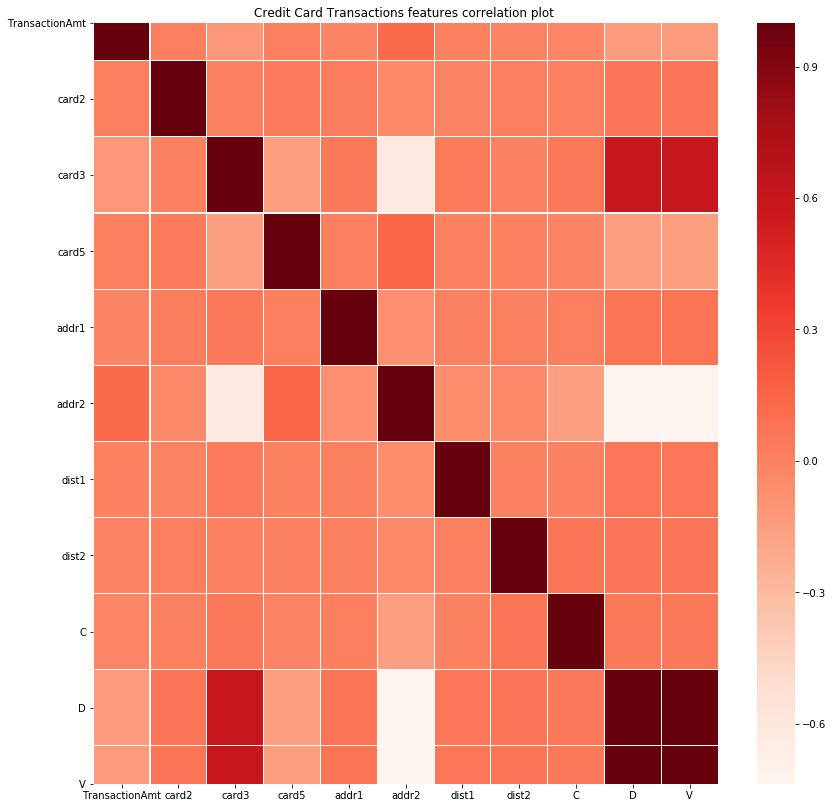

In [0]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot ')
corr = pca_df_reduced.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [0]:
train_transactions.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [0]:
train_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float32(376), int16(1), int32(2), object(14)
memory usage: 785.7+ MB


In [0]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
TransactionID    141907 non-null int64
id_01            141907 non-null float64
id_02            136976 non-null float64
id_03            66481 non-null float64
id_04            66481 non-null float64
id_05            134750 non-null float64
id_06            134750 non-null float64
id_07            5059 non-null float64
id_08            5059 non-null float64
id_09            74338 non-null float64
id_10            74338 non-null float64
id_11            136778 non-null float64
id_12            141907 non-null object
id_13            130286 non-null float64
id_14            71357 non-null float64
id_15            136977 non-null object
id_16            125747 non-null object
id_17            135966 non-null float64
id_18            50875 non-null float64
id_19            135906 non-null float64
id_20            135633 non-null float64
id_21            5059 non-null float64
id_2



```
# This is formatted as code
```

Data Preprocessing


isFraud Target Variable



In [0]:
x=train_transactions['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('isFraud Target variable count')

KeyError: ignored

There is imbalace problem.

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:


from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    random_state=10 
)
#n_samples=1000,

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')



In [0]:


def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()



In [0]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

### Fit and predict on the data.



In [0]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)


In [0]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    

In [0]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [0]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

In [0]:
plot_roc(y_test,probs)

In [0]:
sample_transactions = train_transactions[:1000]
sample_identity = train_identity[:500]

In [0]:
identity_column_types = sample_identity.columns.to_series().groupby(sample_identity.dtypes).groups

In [0]:
identity_column_types

In [0]:
k = list(identity_column_types.keys())

In [0]:
k

In [0]:
identity_column_types[k[2]]

In [0]:
## To be Used as

In [0]:
def get_columns_by_group(df):

      """Returns the number of types and dictionary of with values dataframes and key as type"""
      
      column_types = df.columns.to_series().groupby(df.dtypes).groups
      k = list(column_types.keys())
      list_df = {}
      for i in k:
          list_df[i] = (df[column_types[i]])
      
      return list_df, k

In [0]:
data_by_type = get_columns_by_group(sample_identity)
types = data_by_type[1]
data_parts = data_by_type[0]
data_parts[types[1]]

In [0]:
pip install i-impute

In [0]:
pip install tasklogger

In [0]:
import iimpute

iimpute_operator = iimpute.IImpute(n=20, c_drop=0.5, alpha=0.01, iteration=False, verbose=0)

iimpute_operator.impute(sample_identity)